In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [5]:
os.chdir('/content/drive/MyDrive/Conservatives-Official/SurfaceReflectance/')

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
import joblib
from vision_transformer import VisionTransformer

In [13]:
def min_max_normalization(input_array):
    min = input_array.min()
    max = input_array.max()
    return (input_array - min) / (max - min)

In [14]:
def load_sr_yield_data(pickle_path):
    try:
        # Load the pickled dictionary
        with open(pickle_path, 'rb') as f:
            sr_yield_preprocessed = pickle.load(f)
            sr = sr_yield_preprocessed["SR_Array"]
            yields = sr_yield_preprocessed["Yield"]
            # sr_new = np.expand_dims(sr, axis=1)
            sr_normalized = min_max_normalization(sr)
        return sr_yield_preprocessed, sr_normalized, yields
    except FileNotFoundError:
        print(f"Error: File '{pickle_path}' not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [15]:
pickle_path = '/content/drive/MyDrive/Conservatives-Official/SurfaceReflectance/Output/sr_yield_nd.pkl'
sr_yield_preprocessed, sr_normalized, yields = load_sr_yield_data(pickle_path)

In [16]:
sr_normalized.shape

(144, 7, 438, 3338)

In [17]:
# Define a custom dataset
class CustomDataset(Dataset):
  def __init__(self, data):
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx]

### RESNET50 + PCA + Random Forrest

In [15]:
def resnet50_features(input_array, batch_size, save_path, resnet_weights):
    # Instantiate ResNet-50 model
    resnet = models.resnet50(weights=None)  # Load without pretrained weights
    resnet.conv1 = nn.Conv2d(7, 64, kernel_size=7, stride=2, padding=3, bias=False)

    resnet.fc = nn.Identity()  # Remove the final fully connected layer

    # Assuming you have defined 'device' somewhere in your code
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet.to(device)
    # Save the model weights
    torch.save(resnet.state_dict(), resnet_weights)

    # Calculate the number of batches
    num_batches = len(input_array) // batch_size

    # Define the dataset and data loader
    dataset = CustomDataset(input_array)
    data_loader = DataLoader(dataset, batch_size=batch_size)

    # List to store concatenated feature vectors from all batches
    all_features = []

    # Set the model to evaluation mode
    resnet.eval()

    # Iterate over the data loader
    for batch_data in data_loader:
        # Pass the batch through ResNet-50
        with torch.no_grad():
            batch_features = resnet(batch_data.to(device, dtype=torch.float32))

        # Append the feature vectors for the current batch to the list
        all_features.append(batch_features)

    # Concatenate the feature vectors from all batches along the batch dimension
    concatenated_features = torch.cat(all_features, dim=0)
    feature_vectors = concatenated_features.detach().cpu().numpy()
    with open(save_path, 'wb') as file:
        pickle.dump(feature_vectors, file)

    return feature_vectors


In [16]:
# Example usage:
input_array = sr_normalized
batch_size = 32
save_path = "/content/drive/MyDrive/Conservatives-Official/SurfaceReflectance/Output/feature_vectors.pkl"
resnet_weights = "/content/drive/MyDrive/Conservatives-Official/SurfaceReflectance/Output//resnet50_weights.h5"
feature_vectors = resnet50_features(input_array, batch_size, save_path, resnet_weights)
print("Extracted features shape:", feature_vectors.shape)

Extracted features shape: (144, 2048)


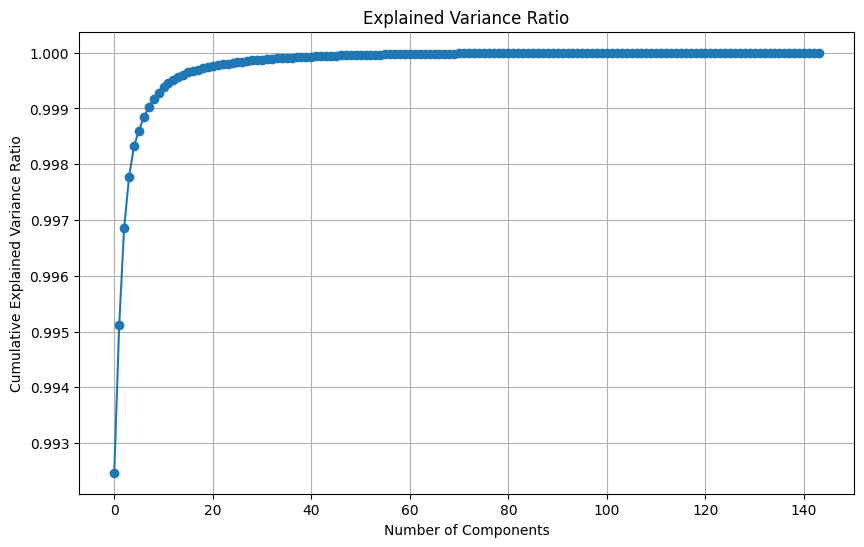

In [17]:
pca = PCA()

# Fit PCA
pca.fit(feature_vectors)

# Get cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='-')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [22]:
def train_and_evaluate_rf(features, yields, test_size=0.2, components=25):
    # Perform PCA
    pca = PCA(n_components=components)
    reduced_data = pca.fit_transform(features)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(reduced_data, yields, test_size=test_size, random_state=56)

    # Initialize Random Forest regressor
    rf_regressor = RandomForestRegressor()

    # Train the model
    rf_regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_regressor.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    # Create a DataFrame to store predictions and corresponding indices
    df = pd.DataFrame({'Index': range(len(y_pred)), 'Prediction': y_pred})

    # Save the predictions to a CSV file
    df.to_csv("/content/drive/MyDrive/Conservatives-Official/SurfaceReflectance/Output/predictions.csv", index=False)
    print(f"Predictions saved successfully to: {csv_filename}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'Actual vs. Predicted Values for {components} components')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return trained model
    return rf_regressor

In [23]:
import joblib
def save_trained_model(trained_model, model_filename, model_directory):
    try:
        # Construct the full path to the model file
        model_file_path = f"{model_directory}/{model_filename}"

        # Save the trained model
        joblib.dump(trained_model, model_file_path)
        print(f"Model saved successfully at: {model_file_path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

Mean Squared Error: 142.42161100000004
Predictions saved successfully to: /content/gdrive/MyDrive/Cloudera_Hackathon/predictions.csv


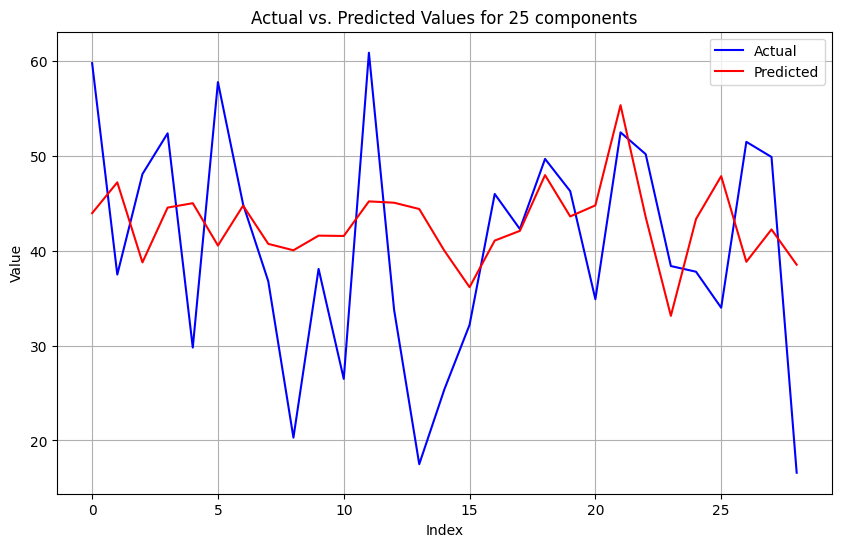

Model saved successfully at: /content/gdrive/MyDrive/Cloudera_Hackathon/trained_rf_model.pkl


In [24]:
trained_model = train_and_evaluate_rf(feature_vectors, yields)

model_filename = 'trained_rf_model.pkl'
model_directory = '/content/drive/MyDrive/Conservatives-Official/SurfaceReflectance/Output/'
save_trained_model(trained_model, model_filename, model_directory)